# COGS 108 Final Project

### Overview

Our team studied the relationship between soccer players and how injuries affected their performance. We looked at eighty players across the four major professional leagues and analyzed their injury history, comparing their respective statistics/performance pre-injury and post-injury. We then categorized these players into which positions they played, and studied the differences in injury frequency across these aforementioned positions.

### Names and group member IDs



Christian Atsin (XXXXXXXXX) <br>
Neel Srejan (XXXXXXXXX) <br>
Elaf Elkadi (XXXXXXXXX) <br>
Zhen Xu (XXXXXXXXX)

## Research Question

What’s the relationship between injuries and consistency of player performance? Does the player’s position determine the frequency at which they suffer injuries?

## Background and Prior Work

There are two characteristics that any great soccer player possesses; consistency and longevity. These two attributes are influenced by many traits of the player. Some are under their control: their professionalism and their ambition. Other traits are natural and the player seems to be born with such a natural talent for soccer. However, there is one aspect of a footballer’ success that is somewhat out of their control: the injuries that they will suffer over the course of their career. 

While some players seem to be particularly prone to injury and a careful training regime or sport science department can reduce the likelihood of injury, many of the injuries that happen on the field cannot be avoided and are often the result of bad luck. All of the attributes mentioned above will collectively determine a player’s consistency and longevity in soccer. Because injuries are such an important part in the development of these players, it undeniably affects the height and time of a player’s peak. On the other end, injuries also tend to herald the decline of a player’s career. In our project, we will analyse the relationship between injuries and consistency of soccer player performance and how the player’s position could determine the frequency at which they suffer injuries.

References: <br>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4495432/ <br>
https://bjsm.bmj.com/content/bjsports/24/4/265.full.pdf <br>
http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0103-51502017000500249

## Hypothesis

We hypothesize that an accumulation of injuries throughout a season negatively affects a player’s performance during that season. We also hypothesize that more physical positions, such as defender, accrue more injuries throughout their footballing career as opposed to midfielders and forwards. 

We believe that due to lack of match fitness, low chemistry with fellow teammates, and insufficient recovery time, a player struggles to return from injury and provide peak performances. This leads to a lack of self-confidence, which in turn also negatively impacts the player’s ability to perform at the highest level. We conjecture that defenders are more susceptible to injury because of the physicality of the position coupled with their involvement in every phase of play.

## Dataset(s)

Dataset Name: Transfermarkt <br>
Link to the dataset: https://www.transfermarkt.com  <br>
Number of observations: 80 <br>
This website contains in-depth information on a player’s injury history, including the dates they were injured, the type of injury, and how many matches they missed due to the injury. <br> <br>
Dataset Name: WhoScored.com <br>
Link to the dataset: https://www.whoscored.com <br>
Number of observations: 80 <br>
This website compiles different performance statistics of individual players on a season-to-season basis, compounded into an overall player rating for that season. <br> <br>
We plan to analyze the amount of injuries a player has accumulated within a season using the data from TransferMarkt, then using that information to analyze the player’s rating for that season gathered from WhoScored’s website. 


## Setup and Data Cleaning

The next cell imports all the packages needed for the project.
We use Selenium for Webscraping transfermarkt and whoscored.
We use joblib to speed up the process by allowing parralelization.
We also use json to write and read files.

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, StaleElementReferenceException
from joblib import Parallel, delayed
import json
import numpy as np

While we were able to get the IDs of all the players involved, some players had multiple pages
of injuries therefore we had to get the links to all those pages to get the parallel code 
running smoothly. The following function took care of that

In [ ]:
def get_links(link):
    option = webdriver.ChromeOptions()
    option.add_argument('--incognito')
    option.add_argument('--disable-extensions')

    try:
        browser = webdriver.Chrome(executable_path='C:/Users/chris/ChromeDriver/chromedriver',
                                   chrome_options=option)
        timeout = 5
        browser.get(link)

        try:
            WebDriverWait(browser, timeout).until(EC.presence_of_element_located((By.XPATH, '//table[@class="items"]')))
        except TimeoutException:
            browser.quit()
            return [link]

        pages = browser.find_elements_by_xpath('//li[@class="page"]/a')
        i_links = [link]
        if len(pages) > 0:
            for page in pages:
                i_links.append(page.get_attribute('href'))
        browser.quit()
        return i_links

    except Exception as e:
        browser.quit()
        return [link]

The following cell calls the function above and saves the links in a textfile

In [ ]:
indices = ['4380', '3332', '26399', '47082', '63200', '28003', '8198', '18922', '65278', '227961',
               '80351', '64793', '28936', '29605', '35743', '38253', '58358', '39106', '48298', '21175',

               '50362', '44068', '3333', '35518', '35664', '31909', '65230', '34601', '39381', '32467',
               '44017', '57995', '30059', '35207', '38410', '26105', '44162', '38593', '41982', '44716',

               '20007', '102258', '15773', '69751', '85258', '44501', '33648', '96718','57500', '34691',
               '33947', '35208', '25727', '40605', '49723', '16631', '55769', '85605', '11', '21763',

               '67355', '42412', '47713', '9594', '76277', '67080', '18944', '25557', '54928', '184767',
               '26485', '39728', '43512', '51676', '52348', '29260', '39983', '111347', '34198', '102745']
links = []
for index in indices:
    links.append('https://www.transfermarkt.us/lionel-messi/verletzungen/spieler/{}'.format(index))

results = Parallel(n_jobs=-1)(delayed(get_links)(link) for link in links)

open('injurylinks.txt', 'w').close()
f = open('injurylinks.txt', 'a+')
for lists in results:
    for entry in lists:
        f.write(entry)
        f.write('\n')
f.close()

Now that we have all the links required for our dataset, we can finally start getting the
injury data from transfermarkt. The following function takes care of that

In [ ]:
def get_injury_data(link):
    option = webdriver.ChromeOptions()
    option.add_argument('--incognito')
    option.add_argument('--disable-extensions')

    try:
        browser = webdriver.Chrome(executable_path='C:/Users/chris/ChromeDriver/chromedriver',
                                   chrome_options=option)
        timeout=10
        browser.get(link)

        try:
            WebDriverWait(browser, timeout).until(EC.presence_of_element_located((By.XPATH, '//table[@class="items"]')))
        except TimeoutException:
            browser.close()
            return 'Timed Out with link {}'.format(link)

        name = browser.find_element_by_xpath('//h1[@itemprop="name"]').text
        injuries = browser.find_elements_by_xpath('//tbody/tr')
        injury_data = {'name': name}
        for injury in injuries:
            cells = injury.find_elements_by_tag_name('td')
            cell_data = [x.text for x in cells]
            if cell_data[0] in injury_data.keys():
                injury_data[cell_data[0]].append(cell_data[1:])
            else:
                injury_data[cell_data[0]] = [cell_data[1:]]

        browser.close()
        return injury_data


    except Exception as e:
        browser.close()
        return 'Error {} has happened with link {}'.format(str(e), link)

The next cell calls the function above and saves the injury data in a json file.

In [ ]:
g = open('injurylinks.txt', 'r')
links = g.read().splitlines()

data_players = Parallel(n_jobs=-1)(delayed(get_injury_data)(link) for link in links)
open('injurydata.json', 'w').close()
f = open('injurydata.json', 'a+')
for entry in data_players:
    json.dump(entry, f)
    f.write('\n')
f.close()

Some of the data scraped from transfermarkt was either not in a format that we liked or
unnecessary for our project. So we did the following things to clean the data:
Since there were multiple entries of the same player throughout the injury data file, we
aggregated all the data for every player in a dictionary
The year was only represented by the last two digits so we added 2000 to every year. All of our 
years were greater than 2000
We then grabbed the relevant datapoints needed for our analysis. They were the total number of
injuries in the season, the number of major injuries (injuries lasting more than 28 days),
the number of games missed in the season, and the number of times a player was rested in the
season
Finally, we wrote all of the injury data to a csv file to make it easily compatible

In [ ]:
g = open('injurydata.json', 'r')
players = g.read().splitlines()
player_table = []
player_dict = {}
for player_string in players:
    player = json.loads(player_string)
    print(player)
    if not player['name'] in player_dict.keys():
        player_dict[player['name']] = {}
    player_data = player_dict[player['name']]
    player_keys = player.keys()
    for player_key in player_keys:
        if not (player_key == 'name'):
            year = int(player_key.split('/')[0]) + 2000
            if year >= 2009:
                injuries = player[player_key]
                if year not in player_data.keys():
                    player_data[year] = {}
                    player_data[year]['n_injuries'] = len(injuries)
                    player_data[year]['n_major_injuries'] = 0
                    player_data[year]['n_games_missed'] = 0
                    player_data[year]['n_rested'] = 0
                else:
                    player_data[year]['n_injuries'] += len(injuries)
                for injury in injuries:
                    if injury[0] == 'Rest':
                        player_data[year]['n_injuries'] -= 1
                        player_data[year]['n_rested'] += 1
                    if int(injury[-2].split(' ')[0]) > 28:
                        player_data[year]['n_major_injuries'] += 1
                        player_data[year]['n_games_missed'] += int(injury[-1].replace('-', '0').replace('?', '-1'))

all_players = player_dict.keys()

for k in all_players:
    all_years = player_dict[k].keys()
    for y in all_years:
        p = player_dict[k][y]
        player_table.append([k, str(y), str(p['n_injuries']), str(p['n_major_injuries']),
                             str(p['n_games_missed']), str(p['n_rested'])])

h = open('player_injuries.csv', 'w')
for entry in player_table:
    h.write(','.join(entry))
    h.write('\n')
h.close()

Next we needed to get the seasonal ratings for every player so we could put it against their
injury record. The following function scrapes whoscored for player ratings

In [ ]:
def get_whoscored_data(link):
    option = webdriver.ChromeOptions()
    option.add_argument('--incognito')
    option.add_argument('--disable-extensions')
    browser = webdriver.Chrome(executable_path='C:/Users/chris/ChromeDriver/chromedriver',
                               chrome_options=option)

    try:
        timeout=30
        browser.get(link)

        try:
            WebDriverWait(browser, timeout).until(EC.presence_of_element_located((
                By.ID, 'player-table-statistics-body')))
        except TimeoutException:
            browser.close()
            return None

        name = browser.find_element_by_xpath('//tr[@class=" selected"]/td/a[@class="player-link "]').text
        positions = browser.find_element_by_xpath('//tr[@class=" selected"]/td[@class="pos"]').text
        player_stats = {'name': name, 'positions': positions.split(',')}
        rows = browser.find_elements_by_xpath('//tbody[@id="player-table-statistics-body"]/tr')
        for row in rows[0:-1]:
            competition = row.find_element_by_xpath('.//td[@class="tournament"]/a').text.strip()
            if competition in ['SLL', 'EPL', 'GB', 'ISA']:
                cells = row.find_elements_by_tag_name('td')
                cells_data = [x.text for x in cells]
                player_stats[cells_data[0]] = [cells_data[1:]]
        browser.close()
        return player_stats





    except Exception as e:
        browser.close()
        return e

The next cell calls the function above and stores the data in a json file

In [ ]:
indices = ['4564', '3859', '14260', '23736', '33386', '11119', '5583', '14296', '44055', '140771',
               '29400', '37099', '21488', '30110', '10103', '43194', '95822', '25820', '19792', '15438',

               '27213', '25363', '4511', '14102', '13756', '31772', '44721', '11386', '13812', '22732',
               '14091','44142', '29940', '41330', '82362', '12032', '30226', '13475', '52380', '20211',

               '25931', '15764', '14244', '80067', '18181', '44288', '44739', '20241', '20592', '78500',
               '106590', '43364', '11090', '136753', '69467', '23206', '64271', '33870', '15302', '18723',

               '8408', '22079', '29575', '10136', '30051', '79708', '12712', '9909', '26059', '100881',
               '23589', '21541', '43589', '80418', '133346', '9991', '20664', '128740', '14157', '93211']

links = []
for index in indices:
    links.append('https://www.whoscored.com/Players/{}/History/Lionel-Messi'.format(index))

results = Parallel(n_jobs=-1)(delayed(get_whoscored_data)(link) for link in links)

open('players_whoscored.json', 'w').close()
f = open('players_whoscored.json', 'a+')
for entry in results:
    json.dump(entry, f)
    f.write('\n')
f.close()

The upcoming cells discards all of the injury data scraped, groups players into their general 
positions (CF and RW/LW as forwards, AMC/DMC and MC as midfielders, CB as Center Backs and DR/DL
as full backs). We also grab the rating for every year and write the cleaned up data to a csv
file

In [ ]:
g = open('players_whoscored.json', 'r')
players = g.read().splitlines()
player_table = []
for player_string in players:
    player = json.loads(player_string)
    player_data = [player['name']]
    pos = player['positions']
    if 'FW' in pos:
        player_data.append('Forward')
    elif '(' not in pos[0]:
        player_data.append("Midfielder")
    else:
        pos_1 = pos[0].split('(')[0]
        pos_2 = pos[0].split('(')[1].split(')')[0][0]
        if pos_1 == 'D':
            if pos_2 == 'R' or pos_2 == 'L':
                player_data.append('Full Back')
            else:
                player_data.append('Center Back')
        else:
            player_data.append('Midfielder')
    player_keys = player.keys()
    for key in player_keys:
        if key not in ['name', 'positions']:
            year_data = [key.split('/')[0], player[key][0][-1]]
            player_table.append(player_data + year_data)

h = open('player_ratings.csv', 'w')
for entry in player_table:
    h.write(','.join(entry))
    h.write('\n')
h.close()

   Finally we merge our two datasets and write the merged result into a csv file for EDA

In [ ]:
df_ratings = pd.read_csv('C:/Users/chris/Documents/Python36/COGS108/player_ratings.csv')
df_injuries = pd.read_csv('C:/Users/chris/Documents/Python36/COGS108/player_injuries.csv')
total_df = df_ratings.merge(df_injuries, on=['name', 'year'])
total_df.to_csv('total_df.csv')

## Data Analysis & Results

In [3]:
# Importing libraries that are relevant to create plots from csv data
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn as sns
import statistics

In [2]:
# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Displaying a set amout of rows when printing dataframe at a time
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

Read csv data into dataframe and use the first column as indicies

In [3]:
df_soccer = pd.read_csv('total_df.csv', index_col = 0)

For the plots we only need to look at position, number of injures, and number of games missed. We drop all other columns.

In [4]:
df_soccer.drop(labels = ['name','year', 'rating', 'n_major_injuries', 'n_rested'], axis = 1, inplace = True)

Display cleaned dataframe

In [5]:
print(df_soccer)

             pos  n_injuries  n_games_missed
0        Forward           2               7
1        Forward           3              18
2        Forward           2              14
..           ...         ...             ...
445  Center Back           2               0
446  Center Back           2              13
447  Center Back           3               0

[448 rows x 3 columns]


Iterate through the column of position and based on position find the average number of injuries per position.

In [6]:
tot_injuries_forward = 0
tot_injuries_mid = 0
tot_injuries_cb = 0
tot_injuries_fb = 0
tot_forward = 0
tot_mid = 0
tot_cb = 0
tot_fb = 0
for i in range(0, len(df_soccer)):
    x = df_soccer['pos'][i]
    if x == 'Forward':
        tot_injuries_forward = tot_injuries_forward + df_soccer['n_injuries'][i]
        tot_forward = tot_forward + 1
    elif x == 'Midfielder':
        tot_injuries_mid = tot_injuries_mid + df_soccer['n_injuries'][i]
        tot_mid = tot_mid + 1
    elif x == 'Center Back':
        tot_injuries_cb = tot_injuries_cb + df_soccer['n_injuries'][i]
        tot_cb = tot_cb + 1
    elif x == 'Full Back':
        tot_injuries_fb = tot_injuries_fb + df_soccer['n_injuries'][i]
        tot_fb = tot_fb + 1
        
avg_injuries_forward = tot_injuries_forward/tot_forward
avg_injuries_mid = tot_injuries_mid/tot_mid
avg_injuries_cb = tot_injuries_cb/tot_cb
avg_injuries_fb = tot_injuries_fb/tot_fb

Create a bar graph showing position vs average number of injuries

Text(0, 0.5, 'Average Injuries')

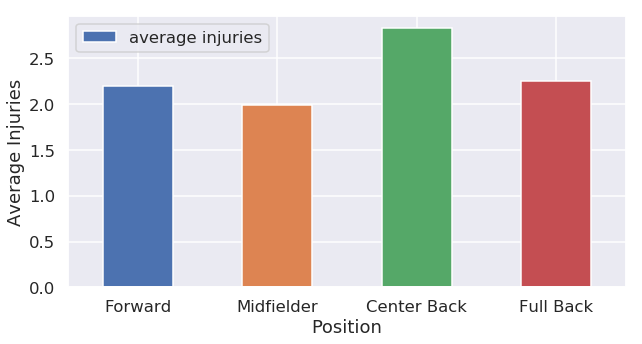

In [7]:
position = ['Forward', 'Midfielder', 'Center Back', 'Full Back']
avg_injured_byPosition = [avg_injuries_forward, avg_injuries_mid, avg_injuries_cb, avg_injuries_fb]
df_injuries = pd.DataFrame({'Position': position, 'average injuries':avg_injured_byPosition})
plot = df_injuries.plot.bar(x='Position', y='average injuries', rot=0, figsize = (10,5))
plot.set_ylabel('Average Injuries')

Fig 1. The above bar graph shows a the player position versus the average injuries incurred. <br>

Iterate through the column of position and based on position find the average number of missed games per position.

In [8]:
tot_missed_forward = 0
tot_missed_mid = 0
tot_missed_cb = 0
tot_missed_fb = 0
tot_forward = 0
tot_mid = 0
tot_cb = 0
tot_fb = 0
for i in range(0, len(df_soccer)):
    x = df_soccer['pos'][i]
    if x == 'Forward':
        tot_missed_forward = tot_missed_forward + df_soccer['n_games_missed'][i]
        tot_forward = tot_forward + 1
    elif x == 'Midfielder':
        tot_missed_mid = tot_missed_mid + df_soccer['n_games_missed'][i]
        tot_mid = tot_mid + 1
    elif x == 'Center Back':
        tot_missed_cb = tot_missed_cb + df_soccer['n_games_missed'][i]
        tot_cb = tot_cb + 1
    elif x == 'Full Back':
        tot_missed_fb = tot_missed_fb + df_soccer['n_games_missed'][i]
        tot_fb = tot_fb + 1
        
avg_missed_forward = tot_missed_forward/tot_forward
avg_missed_mid = tot_missed_mid/tot_mid
avg_missed_cb = tot_missed_cb/tot_cb
avg_missed_fb = tot_missed_fb/tot_fb

Create a bar graph showing position vs average number of games missed

Text(0, 0.5, 'Average Games Missed')

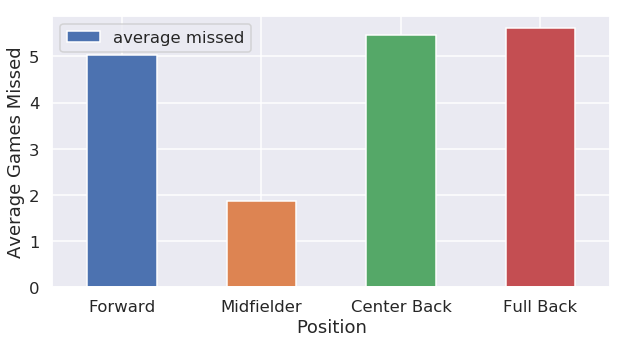

In [9]:
position = ['Forward', 'Midfielder', 'Center Back', 'Full Back']
avg_missed_byPosition = [avg_missed_forward, avg_missed_mid, avg_missed_cb, avg_missed_fb]
df_injuries = pd.DataFrame({'Position': position, 'average missed':avg_missed_byPosition})
plot = df_injuries.plot.bar(x='Position', y='average missed', rot=0, figsize = (10,5))
plot.set_ylabel('Average Games Missed')

Fig 2. The above bar graph shows a the player position versus the average games missed.

Read in new copy of the csv file into a dataframe

In [9]:
df = pd.read_csv('total_df.csv')

For the plots we only need to look at ratings, number of injures, and number of games missed. We drop all other columns.

In [10]:
df = df.drop(['Unnamed: 0','name', 'pos', 'year', 'n_major_injuries', 'n_rested'], axis=1)

Subset values in n_injuries column into less than or equal to 1, 2, 3, 4, 5, or greater than 6 <br>
Subset values in n_games_missed into less than 10, 10-19, 20-29, 30-38 as the max games in a season is 38.

In [11]:
df_one = df[df['n_injuries'] <= 1]
df_two = df[df['n_injuries'] == 2]
df_three = df[df['n_injuries'] == 3]
df_four = df[df['n_injuries'] == 4]
df_five = df[df['n_injuries'] == 5]
df_sixPlus = df[df['n_injuries'] >= 6]

df_lessThanTen = df.loc[(df['n_games_missed'] < 10)]
df_tenToTwenty = df.loc[(df['n_games_missed'] >= 10) & (df['n_games_missed'] < 20)]
df_twentyToThirty = df.loc[(df['n_games_missed'] >= 20) & (df['n_games_missed'] < 30)]
df_thirtyToFourty = df.loc[(df['n_games_missed'] >= 30) & (df['n_games_missed'] < 39)]

Get the means of ratings of the players in each of the 6 subsets of n_injuries <br>
Get the means of ratings of the players in each of the 4 subsets of n_games_missed

In [12]:
mean_one = statistics.mean(df_one['rating'])
mean_two = statistics.mean(df_two['rating'])
mean_three = statistics.mean(df_three['rating'])
mean_four = statistics.mean(df_four['rating'])
mean_five = statistics.mean(df_five['rating'])
mean_sixPlus = statistics.mean(df_sixPlus['rating'])

mean_o = statistics.mean(df_lessThanTen['rating'])
mean_t = statistics.mean(df_tenToTwenty['rating'])
mean_th = statistics.mean(df_twentyToThirty['rating'])
mean_f = statistics.mean(df_thirtyToFourty['rating'])

Create a dataframe for the n_injuries subset and avg player rating   <br>
Create a dataframe for the n_games_missed subset and avg player rating

In [13]:
final_df = pd.DataFrame({'Number of Injuries':['>=1', '2', '3', '4', '5', '<=6'], 'Average Rating':[mean_one, mean_two, mean_three, mean_four, mean_five, mean_sixPlus]})
final_df2 = pd.DataFrame({'Number of Games Missed':['>10', '10 to 20','20 to 30', '30 to 40'], 'Average Rating':[mean_o, mean_t, mean_th, mean_f]})

Create a line plot of Number of Injuries vs Average Rating <br>
Create a line plot of Number of Games Missed vs Average Rating

Text(0, 0.5, 'Average Rating')

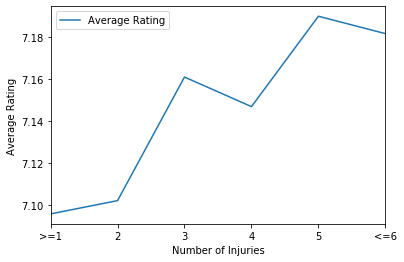

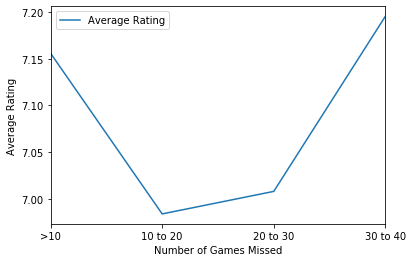

In [14]:
ax = final_df.plot(x='Number of Injuries', y='Average Rating', rot=0, xticks=final_df.index)
ax.set_ylabel("Average Rating")

ax2 = final_df2.plot(x='Number of Games Missed', y='Average Rating', rot=0, xticks=final_df2.index)
ax2.set_ylabel("Average Rating")

Fig 3 (top): The line graph above shows the change in average rating with respect to number of injuries. <br>
Fig 4 (bottom): The line graph above shows the change in average rating with respect to number of games missed.

### Statistics of results

A one way anova test was used along with a Tukey HSD Post-hoc Test to give a p value between the various categories that were being compared against eachother in the anova test. We use an alpha value of 0.05 to compare the p value.
H0: There is no statistical significance between said y values of given x categories. 
Ha: There is a statistical significance between said y values of given x categories. 

Fig 1:<br>
forward vs midfield: Diff=-0.2100, 95%CI=-0.8170 to 0.3970, p=0.8091<br>
forward vs center back: Diff=0.6300, 95%CI=0.1403 to 1.1197, **p=0.0054**<br>
forward vs full back: Diff=0.0500, 95%CI=-0.5387 to 0.6387, p=0.9962<br>
midfield vs center back: Diff=0.8400, 95%CI=0.2350 to 1.4450, **p=0.0021**<br>
midfield vs full back: Diff=0.2600, 95%CI=-0.4275 to 0.9475, p=0.7638<br>
center back  vs fullback: Diff=-0.5800, 95%CI=-1.1666 to 0.0066, p=0.0539<br>
<br>
Fig 2:<br>
forward vs midfield: Diff=-3.1600, 95%CI=-6.2553 to -0.0647, **p=0.0433**<br>
forward vs center back: Diff=0.4200, 95%CI=-2.0773 to 2.9173, p=0.9727<br>
forward vs full back: Diff=0.5700, 95%CI=-2.4318 to 3.5718, p=0.9614<br>
midfield vs center bac: Diff=3.5800, 95%CI=0.4949 to 6.6651, **p=0.0154**<br>
midfield vs full back: Diff=3.7300, 95%CI=0.2240 to 7.2360, **p=0.0320**<br>
center back  vs fullback: Diff=0.1500, 95%CI=-2.8413 to 3.1413, p=0.9992<br>
<br>
Fig 3:<br>
<=1 vs 2: Diff=0.0000, 95%CI=-0.1509 to 0.1509, p=1.0000<br>
<=1 vs 3: Diff=0.0600, 95%CI=-0.1117 to 0.2317, p=0.9179<br>
<=1 vs 4: Diff=0.0500, 95%CI=-0.1873 to 0.2873, p=0.9908<br>
<=1 vs 5: Diff=0.0900, 95%CI=-0.1928 to 0.3728, p=0.9437<br>
<=1 vs 6: Diff=0.0800, 95%CI=-0.1706 to 0.3306, p=0.9430<br>
2 vs 3: Diff=0.0600, 95%CI=-0.1255 to 0.2455, p=0.9398<br>
2 vs 4: Diff=0.0500, 95%CI=-0.1974 to 0.2974, p=0.9924<br>
2 vs 5: Diff=0.0900, 95%CI=-0.2013 to 0.3813, p=0.9502<br>
2 vs >=6: Diff=0.0800, 95%CI=-0.1802 to 0.3402, p=0.9512<br>
3 vs 4: Diff=-0.0100, 95%CI=-0.2706 to 0.2506, p=0.9999<br>
3 vs 5: Diff=0.0300, 95%CI=-0.2727 to 0.3327, p=0.9997<br>
3 vs >=6: Diff=0.0200, 95%CI=-0.2529 to 0.2929, p=0.9999<br>
4 vs 5: Diff=0.0400, 95%CI=-0.3041 to 0.3841, p=0.9995<br>
4 vs >=6: Diff=0.0300, 95%CI=-0.2882 to 0.3482, p=0.9998<br>
5 vs >=6: Diff=-0.0100, 95%CI=-0.3635 to 0.3435, p=1.0000<br>
<br>
Fig 4:<br>
<10 vs 10-20: Diff=-0.3500, 95%CI=-0.6410 to -0.0590, **p=0.0110**<br>
<10 vs 20-30: Diff=-0.1200, 95%CI=-0.2920 to 0.0520, p=0.2750<br>
<10 vs 30-38: Diff=0.0400, 95%CI=-0.3947 to 0.4747, p=0.9952<br>
10-20 vs 20-30: Diff=0.2300, 95%CI=-0.0971 to 0.5571, p=0.2686<br>
10-20 vs 30-38: Diff=0.3900, 95%CI=-0.1261 to 0.9061, p=0.2095<br>
20-30 vs 30-38: Diff=0.1600, 95%CI=-0.2996 to 0.6196, p=0.8061<br>

#### Statistically significant

Fig 1 shows that there is a statistically significant difference in number of injuries and position in the positions between a forward and a center back as well as between a midfielder and a center back. <br>
<br>
Fig 2 shows that there is a statistically significant difference in the number of games missed and position from the positions between a forward and a midfielder, center back and a midfielder and a fullback and a midfielder.<br>
<br>
Fig 3 shows that there are no relavent differences in any number of injuries a player may endure and the rating of their performance through the seasons. <br>
<br>
Fig 4 shows that there is a statistically significant difference in the number of games missed in a season and overall rating of of their performances through the season.

## Ethics and Privacy Considerations

### Who will be affected by our work?  
Our team needs to take into consideration the possible ramifications of what our project analysis and data could mean for those persons/entities whose data we manipulate and derive a conclusion from.  Could this possibly destroy organizations/careers, cause irreversible damage or harm, influence politics or the economy etc. Need to be conscious of the effects of our work every step of the way.  It’s possible that in some scenarios we’ll have to weigh the possible negatives and positives that could result in publishing our analysis and make a judgement based on that on whether to continue.

### Is our group introducing any bias? 
The variables taken into consideration are subject to selection bias.  As we analyze and pick our data our team needs to be aware that it’s possible we are incorporating our personal biases.  These biases will then inevitably be reflected in our algorithms and results.  Therefore we should consider that, check each other, to try and reduce potential bias and work to stay as objective as we can. 

### Protecting the privacy and identity of individuals/groups/entities.  
Any data in which we use to showcase an analysis, observation, or conclusion that could potentially be viewed by the public must have been gathered from legitimate sources in which the source of that data was obtained and made available through legal procedures.  Sources of data obtained illegally and/or without permission or are questionable at best are better off avoided to ensure that we are not breaching an individuals or entities privacy and data.

### Recognizing we aren’t experts.
An experiment is limited by our own knowledge, therefore it is important that we recognize the limitations of our background and do our due diligence in finding out more information as necessary and becoming familiar with a topic.  In order to deliver an insightful and well thought out conclusion or analysis, we must also have a reasonable amount of knowledge in a topic.  For example when we analyze data we should probably have a foundation of knowledge and research into the subject at hand, so as to use that data as effectively as possible.


## Conclusion & Discussion


Our team hypothesized that an accumulation of injuries throughout a season would negatively affect a soccer player's performance during that season. After scraping the data related to player ratings throgh multiple seasons and the amount of injuries they accrued in those seasons, we've come to see (Fig 1) that injuries are fewer for midfielders as when midfielders are compared to all other positions they have a statistically significant difference. We consider fullbacks to be insignificant as it is minimally not significant as 0.0539 is quite close to the threshold of 0.05.
With this consideration in mind, Fig 2 shows the result of that being that midfielders all have a significant difference with all other positions in regards to the number of games missed. Considering that they are statistically more likely to not get injured, there is no reason for the midfielder to miss a game due to injury. <br>
<br>
Along with our hypothesis, we must not just took at games missed but their performance and ability to play at a high level at all times. Fig 3's results of no significant differences between injuries and ratings shocked us. We believed that if one was injured, it would take a rather long time to get back into their prime performances. Rather through looking at Fig 4, we see that missing 0-9 games doesn't really affect performance, only if one misses 10-20 games through an injury is when we see a statistically significant difference in rating. <br>
<br>

After discussion within our team we believe that there is a lot more things that go into injuries and performances that we seem to overlook. With injuries players are allowed rest and recovery through sports science and calculated steps to recover and come back stronger than before. Such is the case that the body and mind are more rested than the players who fatigue themselves through constant play. In addition to the interesting relationship midfielders posess, looking at thier position seems to show the rather glaring reason why this relationship is seen. Forwards are usually running at full pace and if they are tackled they get injured, likewise the forwards getting tackled by fullbacks who try to prevent crosses. More than that the goal is in the center of the field and thus all attention and power as the last line of defense seems to be that of the center back. Through this view of the game, we see that the midfielder is usually further back passing the ball and do not have the upmost responsiblity and risk of being hurt in tackling or other aspects of the game. <br>
<br> 
Our analysis is limited to average ratings across seasons, rather than on a game by game basis pre and post injury. This gives us a broad view of how injuries affect players throughout an entire season, rather than how injuries affect them in the individual games immediately after returning from injury. We are also limited by our lack of information on team performance throughout a season, a variable that also affects player performance, regardless of injury. These factors needed to be kept in mind when discussing our analysis and looking forward to seeing how one can potentially reduce injuries and bolster ratings from games. 
